<a href="https://colab.research.google.com/github/VB-123/OFDM_Capstone/blob/main/OFDM_Capstone_AWGN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# OFDM Transmitter

#### ToDo:
- functions for grouping
- classes for grouping

In [2]:
bit_stream = np.random.randint(0,2,7752*4)
# np.save('bit_stream.npy', bit_stream)

In [18]:
# CONSTANTS
N = 64
max_delay = 0
NUM_SC = 612
NUM_SLOTS = 14
cp_length = 144
#snr_dB = 14

In [4]:
# Generate Data and modulate

qam_map = {
    (0,0,0,0):  1 + 1j,
    (0,0,0,1):  1 + 3j,
    (0,0,1,1):  1 - 3j,
    (0,0,1,0):  1 - 1j,

    (0,1,0,0):  3 + 1j,
    (0,1,0,1):  3 + 3j,
    (0,1,1,1):  3 - 3j,
    (0,1,1,0):  3 - 1j,

    (1,1,0,0): -3 + 1j,
    (1,1,0,1): -3 + 3j,
    (1,1,1,1): -3 - 3j,
    (1,1,1,0): -3 - 1j,

    (1,0,0,0): -1 + 1j,
    (1,0,0,1): -1 + 3j,
    (1,0,1,1): -1 - 3j,
    (1,0,1,0): -1 - 1j,
}

qam_demap = {v: k for k, v in qam_map.items()}

def qam_mapping(bit_stream):
  L = len(bit_stream)
  bit_grps = [tuple(bit_stream[i:i+4]) for i in range(0, L, 4)]
  qam_symbols = [qam_map[grp] for grp in bit_grps]
  return qam_symbols



In [5]:
data_symbols = qam_mapping(bit_stream)
resource_grid = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
dmrs_indices = np.linspace(10, 8567, 816, dtype=int)  # using a linear DMRS fashion

dmrs_positions = np.array([(i % NUM_SC,  i // NUM_SC) for i in dmrs_indices])
dmrs_symbols = np.array([-1 + 1j, 3 + 1j, 1 - 1j, 1 + 3j])

# sc_idx = subcarrier index, sym_idx = OFDM symbol index
for i, (sc_idx, sym_idx) in enumerate(dmrs_positions):
    resource_grid[sc_idx, sym_idx] = dmrs_symbols[i % 4]

dmrs_mask = np.zeros((NUM_SC, NUM_SLOTS), dtype=bool)
for sc_idx, sym_idx in dmrs_positions:
    dmrs_mask[sc_idx, sym_idx] = True

# Place Data Symbols in the Grid
n = 0 # No. of data symbols counter
data_positions = []
for sym_idx in range(NUM_SLOTS):
  for sc_idx in range(NUM_SC):
    if not dmrs_mask[sc_idx, sym_idx]:
      resource_grid[sc_idx, sym_idx] = data_symbols[n]
      data_positions.append((sc_idx, sym_idx))
      n +=1

Pilots placed: 816
Data symbols used: 7752
Empty resource elements: 0


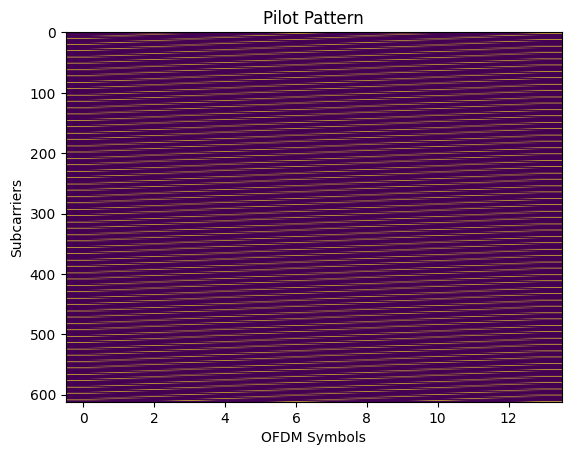

In [6]:
# Resource Grid verification
print(f"Pilots placed: {np.sum(dmrs_mask)}")  # Should be 816
print(f"Data symbols used: {n}")  # Should be 7752
empty_res = np.sum(resource_grid == 0)
print(f"Empty resource elements: {empty_res}")  # Should be 0
plt.imshow(dmrs_mask, aspect='auto')  # .T for proper time/freq orientation
plt.ylabel('Subcarriers')
plt.xlabel('OFDM Symbols')
plt.title('Pilot Pattern')

np.save('resource_grid.npy', resource_grid)

if not (resource_grid == np.load('resource_grid.npy')).all():
  raise ValueError("Resource Grid not matching")

In [7]:
# OFDM and Transmission
# Extract each OFDM symbol (column) for processing
time_domain_symbols = []
for sym_idx in range(NUM_SLOTS):
    frequency_domain_symbol = resource_grid[:, sym_idx]  # 612 subcarriers
    time_domain_symbol = np.fft.ifft(frequency_domain_symbol, 612)
    time_domain_symbols.append(time_domain_symbol)
# Add Cyclic Prefix
cp_length = 144
symbols_with_cp = []
for time_symbol in time_domain_symbols:
    symbol_with_cp = np.concatenate([time_symbol[-cp_length:], time_symbol])
    symbols_with_cp.append(symbol_with_cp)
transmitted_signal = np.concatenate(symbols_with_cp)
# TRANSMITTER
print("=== TRANSMITTER ===")
print(f"Generated {len(data_symbols)} QAM symbols from {len(bit_stream)} bits")
print(f"Placed {np.sum(dmrs_mask)} pilots and {n} data symbols")
print(f"Transmitted signal length: {len(transmitted_signal)}")

=== TRANSMITTER ===
Generated 7752 QAM symbols from 31008 bits
Placed 816 pilots and 7752 data symbols
Transmitted signal length: 10584


## OFDM Transmission System Summary
So far, we have implemented the OFDM Transmission. We generated a bitstream, applied QAM Mapping, then added pilot symbols. Here, we could have added pilots before modulation and modulated the pilots too, but that was pretty confusing to implement - as I had to add 4 bits and they will be modulated and DMRS Indices are hard to calculate. So, I added the QAM symbols corresponding to inputs 1000, 0100, 0010 and 0001 as DMRS symbols.
Then, the symbols are arranged in the 612 * 14 Resource Grid and the same is plotted for reference.

In [8]:
# AWGN Channel
def add_AWGN(signal, snr_dB):
  signal_power = np.mean(np.abs(signal)**2)
  snr = 10 ** (snr_dB/10)
  noise_power = signal_power/snr
  noise_real = np.random.normal(0, np.sqrt(noise_power/2), len(signal))
  noise_imag = np.random.normal(0, np.sqrt(noise_power/2), len(signal))
  noise = noise_real + 1j * noise_imag
  received_signal = signal + noise

  return received_signal, noise

In [27]:
def square_distance(cmplx1, cmplx2):
  return (cmplx1.real - cmplx2.real)**2 + (cmplx1.imag - cmplx2.imag)**2

# turns complex number into bit pattern corrsesponding to closest QAM symbol
def ML_Decoder(qam_symbol):
  qam_symbols = list(qam_demap.keys())
  min_index = np.argmin([square_distance(qam_symbol, sym) for sym in qam_symbols])
  closest_symbol = qam_symbols[min_index]
  return qam_demap[closest_symbol]

# Adds pad_length elements from end of qam_symbols to beginnging
def cyclic_prefix(qam_symbols, pad_length):
  return qam_symbols[-pad_length:] + qam_symbols

# Maps list of complex numbers to a list of bits
def qam_demapping(qam_symbols):
  decoded_bits = []
  for symbol in qam_symbols:
    bits = ML_Decoder(symbol)
    decoded_bits.extend(bits)
  return np.array(decoded_bits)
snr_dB = 24
received_signal, noise = add_AWGN(transmitted_signal, snr_dB)
# CHANNEL - AWGN
print("\n=== CHANNEL ===")
print(f"Added AWGN with SNR = {snr_dB} dB")

print("\n=== RECEIVER ===")
# Receiver
symbol_length = NUM_SC + cp_length
received_symbols = []

for i in range(NUM_SLOTS):
    start_idx = i * symbol_length
    end_idx = start_idx + symbol_length

    if end_idx <= len(received_signal):
        symbol_with_cp = received_signal[start_idx:end_idx]
        symbol_no_cp = symbol_with_cp[cp_length:]
        freq_domain_symbol = np.fft.fft(symbol_no_cp, NUM_SC)
        received_symbols.append(freq_domain_symbol)

# Reconstruct resource grid
received_resource_grid = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
for sym_idx, freq_symbol in enumerate(received_symbols):
    received_resource_grid[:, sym_idx] = freq_symbol

received_data_symbols = []
for sc_idx, sym_idx in data_positions:
    received_data_symbols.append(received_resource_grid[sc_idx, sym_idx])

print(f"Extracted {len(received_data_symbols)} received data symbols")

# Demodulate QAM symbols
decoded_bits = qam_demapping(received_data_symbols)
print(f"Decoded {len(decoded_bits)} bits")
def calculate_mse(original_symbols, received_symbols):
    """Calculate Mean Square Error between symbol constellations"""
    if len(original_symbols) != len(received_symbols):
        min_len = min(len(original_symbols), len(received_symbols))
        original_symbols = original_symbols[:min_len]
        received_symbols = received_symbols[:min_len]

    mse = np.mean(np.abs(np.array(original_symbols) - np.array(received_symbols))**2)
    return mse

mse = calculate_mse(data_symbols, received_data_symbols)
print(f"Mean Square Error (MSE): {mse:.6f}")


=== CHANNEL ===
Added AWGN with SNR = 24 dB

=== RECEIVER ===
Extracted 7752 received data symbols
Decoded 31008 bits
Mean Square Error (MSE): 0.038175



=== METRICS ===
Bit Error Rate (BER): 0.000000
Number of bit errors: 0 out of 31008
Mean Square Error (MSE): 0.094970
Target SNR: 20 dB, Measured SNR: 20.00 dB


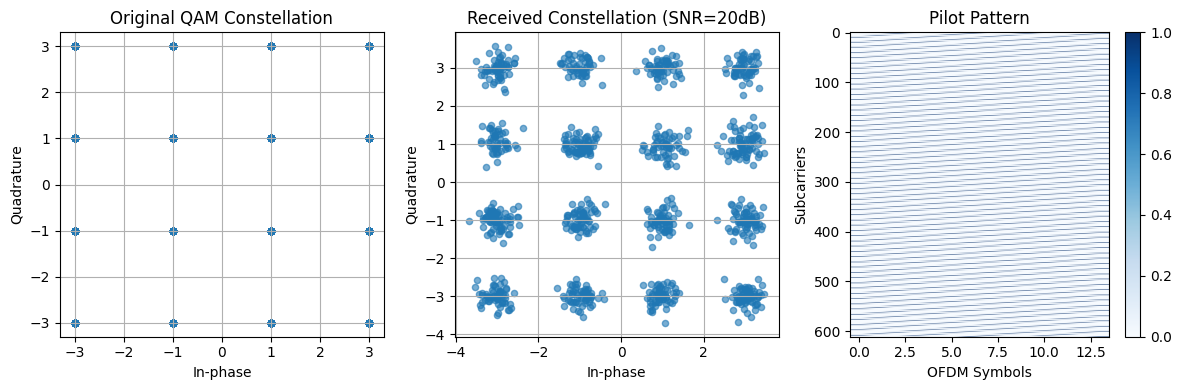


=== BER vs SNR Analysis ===
SNR:  0 dB, BER: 0.286184
SNR:  2 dB, BER: 0.233391
SNR:  4 dB, BER: 0.182501
SNR:  6 dB, BER: 0.137771
SNR:  8 dB, BER: 0.095556
SNR: 10 dB, BER: 0.055308
SNR: 12 dB, BER: 0.024058
SNR: 14 dB, BER: 0.007966
SNR: 16 dB, BER: 0.001225
SNR: 18 dB, BER: 0.000129
SNR: 20 dB, BER: 0.000000
SNR: 22 dB, BER: 0.000000
SNR: 24 dB, BER: 0.000000


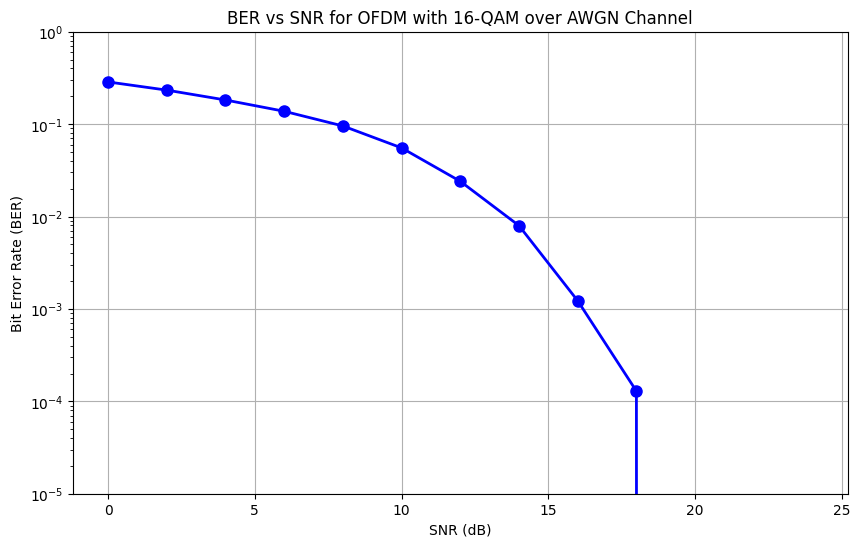


Simulation completed successfully!
Resource grid shape: (612, 14)
Total resource elements: 8568
Pilot overhead: 9.5%


In [ ]:
def calculate_ber(original_bits, decoded_bits):
    """Calculate Bit Error Rate"""
    if len(original_bits) != len(decoded_bits):
        min_len = min(len(original_bits), len(decoded_bits))
        original_bits = original_bits[:min_len]
        decoded_bits = decoded_bits[:min_len]

    errors = np.sum(original_bits != decoded_bits)
    ber = errors / len(original_bits)
    return ber, errors

def calculate_mse(original_symbols, received_symbols):
    """Calculate Mean Square Error between symbol constellations"""
    if len(original_symbols) != len(received_symbols):
        min_len = min(len(original_symbols), len(received_symbols))
        original_symbols = original_symbols[:min_len]
        received_symbols = received_symbols[:min_len]

    mse = np.mean(np.abs(np.array(original_symbols) - np.array(received_symbols))**2)
    return mse
# METRICS
print("\n=== METRICS ===")

# Calculate BER
ber, num_errors = calculate_ber(bit_stream, decoded_bits)
print(f"Bit Error Rate (BER): {ber:.6f}")
print(f"Number of bit errors: {num_errors} out of {len(bit_stream)}")

# Calculate MSE
mse = calculate_mse(data_symbols, received_data_symbols)
print(f"Mean Square Error (MSE): {mse:.6f}")

# Signal-to-Noise Ratio verification
signal_power = np.mean(np.abs(transmitted_signal)**2)
noise_power = np.mean(np.abs(noise)**2)
measured_snr_dB = 10 * np.log10(signal_power / noise_power)
print(f"Target SNR: {snr_dB} dB, Measured SNR: {measured_snr_dB:.2f} dB")

# Plot constellation diagram
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
original_symbols_array = np.array(data_symbols[:1000])  # Plot first 1000 symbols
plt.scatter(original_symbols_array.real, original_symbols_array.imag, alpha=0.6, s=20)
plt.title('Original QAM Constellation')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)

plt.subplot(1, 3, 2)
received_symbols_array = np.array(received_data_symbols[:1000])
plt.scatter(received_symbols_array.real, received_symbols_array.imag, alpha=0.6, s=20)
plt.title(f'Received Constellation (SNR={snr_dB}dB)')
plt.xlabel('In-phase')
plt.ylabel('Quadrature')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.imshow(dmrs_mask, aspect='auto', cmap='Blues')
plt.ylabel('Subcarriers')
plt.xlabel('OFDM Symbols')
plt.title('Pilot Pattern')
plt.colorbar()

plt.tight_layout()
plt.show()

# BER vs SNR Analysis
print("\n=== BER vs SNR Analysis ===")
snr_range = np.arange(0, 25, 2)
ber_results = []

for snr in snr_range:
    # Add noise
    noisy_signal, _ = add_AWGN(transmitted_signal, snr)

    # Receiver processing
    rx_symbols = []
    for i in range(NUM_SLOTS):
        start_idx = i * symbol_length
        end_idx = start_idx + symbol_length

        if end_idx <= len(noisy_signal):
            symbol_with_cp = noisy_signal[start_idx:end_idx]
            symbol_no_cp = symbol_with_cp[cp_length:]
            freq_domain_symbol = np.fft.fft(symbol_no_cp, NUM_SC)
            rx_symbols.append(freq_domain_symbol)

    # Reconstruct and extract data
    rx_resource_grid = np.zeros((NUM_SC, NUM_SLOTS), dtype=complex)
    for sym_idx, freq_symbol in enumerate(rx_symbols):
        rx_resource_grid[:, sym_idx] = freq_symbol

    rx_data_symbols = [rx_resource_grid[sc_idx, sym_idx] for sc_idx, sym_idx in data_positions]
    rx_bits = qam_demapping(rx_data_symbols)

    ber_val, _ = calculate_ber(bit_stream, rx_bits)
    ber_results.append(ber_val)
    print(f"SNR: {snr:2d} dB, BER: {ber_val:.6f}")

# Plot BER vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_range, ber_results, 'bo-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs SNR for OFDM with 16-QAM over AWGN Channel')
plt.ylim([1e-5, 1])
plt.show()

print(f"\nSimulation completed successfully!")
print(f"Resource grid shape: {resource_grid.shape}")
print(f"Total resource elements: {NUM_SC * NUM_SLOTS}")
print(f"Pilot overhead: {np.sum(dmrs_mask) / (NUM_SC * NUM_SLOTS) * 100:.1f}%")

# CHANNEL
 We use the TDL-C Channel Model. In TDL (Tapped Delay Line) channel models, the relative powers of the taps (or paths) are typically specified relative to the strongest path, which is often assigned a power of 0 dB. The other taps have lower power levels, reflecting the attenuation of signals arriving at different delays due to multipath propagation. The relative power of each tap indicates how much weaker it is compared to the strongest tap. For example, if a tap has a relative power of -10 dB, it means that its power is 10 dB lower than the strongest tap.

In [ ]:
# Multipath Channel
Avg_Path_Gains = np.array([-13.4000, 0, -2.2000, -4.0000, -6.0000,	-8.2000, -9.9000, -10.5000,	-7.5000,	-15.9000,
                  -6.6000,	-16.7000,	-12.4000, -15.2,	-10.8,	-11.300,	-12.7,	-16.2,	-18.3,	-18.9	,-16.6, -19.9, -29.7])
Channel_Path_Delays = np.array([0,	1.1457e-07,	1.2075e-07,	1.7604e-07,	1.383e-07,	1.6125e-07,	2.0124e-07,	1.725e-07,	2.2854e-07,
                       4.6125e-07,	5.6934e-07,	6.6726e-07,	6.5154e-07,	7.4826e-07,	7.5357e-07,	9.1746e-07,	1.2243e-06,	1.3373e-06,	1.3709e-06,
                       1.439e-06,	1.502e-06,	1.5913e-06,	2.8976e-06])
maxChDelay = 94
SNRdB = 10

def Jakes_model(n, fd, fs):
  """ n :  no. of samples
      fd: doppler shift
      fs: sampling frequency
  """
  N = 16 # No. of scattering points
  h = np.zeros(num_samples, dtype=complex)
  for n in range(N):
    t = np.arange(N)/fs
